In [3]:
'''A basic introduction to MCMC for inference of dynamical systems models. '''

'A basic introduction to MCMC for inference of dynamical systems models. '

### Introduction

The Metropolis-Hastings algorithm constructs a Markov chain whose stationary distribution is the Bayesian posterior. In this example we will use simple random walk Metropolis to learn a parameter of a dynamical system from noisy partial observations. First we will simulate the model and create some noisy observations. 

The model we will perform inference on is the Van der Pol Oscillator, a two dimensional system with a single scalar parameter $\mu$. We will write the system in the following form 

$$
\frac{dx}{dt} = \mu (x - \frac{1}{3} x^3 - y) \\

\frac{dy}{dt} = \frac{1}{\mu} x.
$$

The observations will be samples of $x$ at regular intervals with an added Gaussian noise.  

In [5]:
from diffrax import diffeqsolve, ODETerm
from jax.scipy.stats import norm,poisson
import diffrax
import jax.numpy as jnp
import jax
import matplotlib.pyplot as plt



ModuleNotFoundError: No module named 'diffrax'

In [ ]:
# Euler's method pip install jax
mu = jnp.log(1.0)

t_vec = jnp.linspace(0,20,400)

def rhs(t,state,args):

    x,y = state
    mu = args
    #exponentiate to enforce positivity
    mu = jnp.exp(mu)

    # Nonlinear cubic term introduces limit cycle behavior.
    dx = mu * (x - 1/3 * x**3 - y)
    # Coupling term creates slow–fast dynamics when mu is large.
    dy = 1/mu * x


    return jnp.array([dx,dy])

In [ ]:
'''The model integrator. Takes the length of time to integrate, the initial condition, and a parameter vector.'''
def model(ts,y0,par):
  solution = diffrax.diffeqsolve(
            ODETerm(rhs),
            diffrax.Tsit5(),
            t0=ts[0],
            t1=ts[-1],
            dt0=ts[1] - ts[0],
            y0=y0,
            args=par,
            saveat=diffrax.SaveAt(ts=ts) #At which points to save the output
        )
  return solution.ys

In [ ]:
rng_key = jax.random.PRNGKey(0)
# Split the key to avoid reusing randomness.
# JAX requires explicit key management to ensure functional purity.
noise_key,rng_key = jax.random.split(rng_key)

'''Simulate model'''
# Initial condition: x(0)=3.0, y(0)=0.5
full_state = model(t_vec,jnp.array([3.,0.5]),(mu))

# Generate noisy observations of the first state component x(t).
noise_std = 1.0
observations = full_state[:,0] + noise_std * jax.random.normal(noise_key,shape = full_state[:,0].shape)



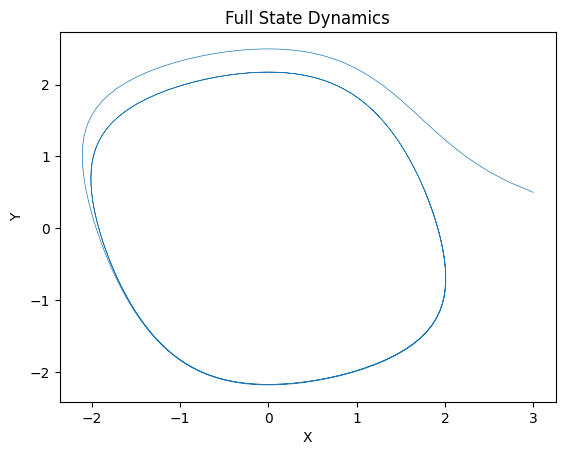

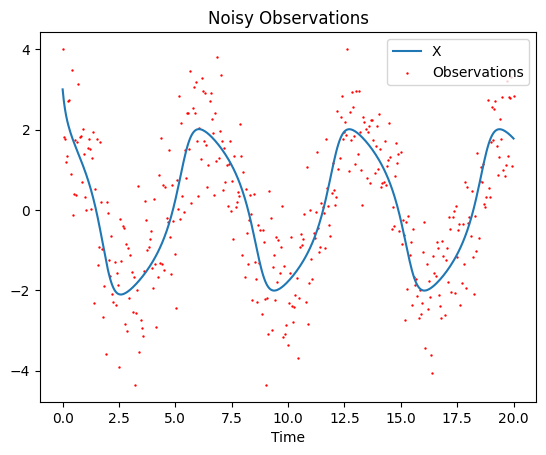

In [ ]:
plt.plot(full_state[:,0],full_state[:,1],lw = 0.5)
plt.title('Full State Dynamics')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

plt.title('Noisy Observations')
plt.plot(t_vec,full_state[:,0],label = 'X')
plt.scatter(t_vec,observations,s = 0.5,color = 'red', label = 'Observations')
plt.xlabel('Time')
plt.legend()
plt.show()


Now that we have our dynamics and our noisy observations, we can construct the Bayesian inference problem. First we will define a prior and likelihood function for our data. 

Our prior for this problem is essentially arbitrary. We will chose a Gaussian prior with mean zero and variance $\tau^2$. 

In [ ]:
'''Prior'''
tau = 5.0

@jax.jit
def log_prior(par,tau): 
    mu = par
    return jax.scipy.stats.norm.logpdf(mu,scale = tau)

Now for the likelihood. We will define our likelihood based on our observational noise for this toy model. Obviously in practice this observational noise will not be known exactly so we will need to choose our likelihood function based on heuristics or an informed guess. 

In [ ]:
@jax.jit
def log_likelihood(par):
  mu = par
  model_output = model(t_vec,jnp.array([3.,0.5]),(mu))
  return jnp.sum(jax.scipy.stats.norm.logpdf(observations, model_output[:,0],scale = noise_std))

### Metropolis-Hastings

To construct a Markov Chain targeting the posterior distribution 

$$
\begin{aligned}
P(\theta|Y_{1:t}) = \frac{P(Y_{1:t}|\theta)P(\theta)}{P(Y_{1:t})}
\end{aligned}
$$

where $P(\theta)$ is the prior and $P(Y_{1:t}|\theta)$ is the likelihood we will use the Metropolis algorithm. The Metropolis algorithm proceeds as follows. 

1. Initial guess of $\theta$ from prior. $\theta_{0} \sim P(\theta)$ 

In [ ]:
thetas = []
LL = []

sample_key,rng_key = jax.random.split(rng_key)

theta_0 = tau * jax.random.normal(sample_key)
thetas.append(theta_0)

LL_0 = log_likelihood(theta_0) + log_prior(theta_0,tau)
LL.append(LL_0)

##MH
iterations = 10000

proposal_std = 0.15

acceptances = []

for iter in range(1,iterations): 
    ##Proposal 
    prop_key,rng_key = jax.random.split(rng_key)
    theta_prop = thetas[-1] + proposal_std * jax.random.normal(prop_key)

    LL_prop = log_likelihood(theta_prop) + log_prior(theta_prop,tau)
    alpha = LL_prop - LL[-1]

    rng_key, accept_key = jax.random.split(rng_key)
    if jnp.log(jax.random.uniform(minval = 0., maxval = 1., key = accept_key)) < alpha:
        LL.append(LL_prop)
        thetas.append(theta_prop)
        acceptances.append(1)

    else: 
        LL.append(LL[-1])
        thetas.append(thetas[-1])
        acceptances.append(0)

    print(f"iteration: {iter} | Acceptance rate: {sum(acceptances)/iter} | mu: {jnp.exp(thetas[-1])}")

    




iteration: 1 | Acceptance rate: 1.0 | mu: 2.0401337146759033
iteration: 2 | Acceptance rate: 0.5 | mu: 2.0401337146759033
iteration: 3 | Acceptance rate: 0.6666666666666666 | mu: 2.009962797164917
iteration: 4 | Acceptance rate: 0.75 | mu: 1.7983804941177368
iteration: 5 | Acceptance rate: 0.8 | mu: 1.3357627391815186
iteration: 6 | Acceptance rate: 0.6666666666666666 | mu: 1.3357627391815186
iteration: 7 | Acceptance rate: 0.7142857142857143 | mu: 1.2215934991836548
iteration: 8 | Acceptance rate: 0.75 | mu: 1.0548954010009766
iteration: 9 | Acceptance rate: 0.6666666666666666 | mu: 1.0548954010009766
iteration: 10 | Acceptance rate: 0.6 | mu: 1.0548954010009766
iteration: 11 | Acceptance rate: 0.5454545454545454 | mu: 1.0548954010009766
iteration: 12 | Acceptance rate: 0.5 | mu: 1.0548954010009766
iteration: 13 | Acceptance rate: 0.46153846153846156 | mu: 1.0548954010009766
iteration: 14 | Acceptance rate: 0.42857142857142855 | mu: 1.0548954010009766
iteration: 15 | Acceptance rate: 

KeyboardInterrupt: 

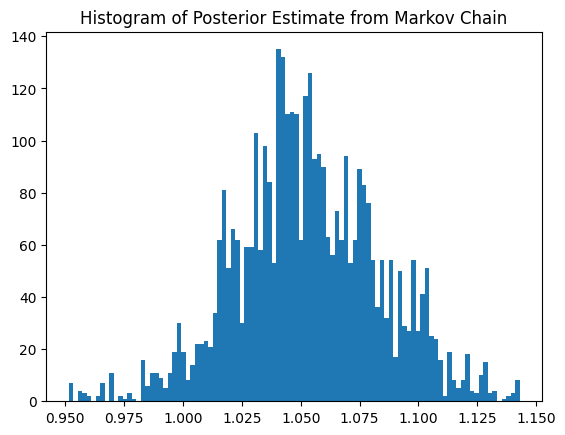

In [ ]:
burn_in = 100
plt.title('Histogram of Posterior Estimate from Markov Chain')
plt.hist(jnp.exp(jnp.array(thetas[burn_in:])),bins = 100)
plt.show()


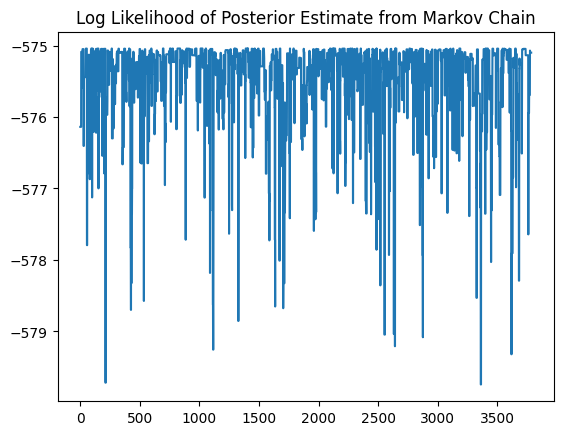

In [ ]:
plt.title('Log Likelihood of Posterior Estimate from Markov Chain')
plt.plot(LL[burn_in:])
plt.show()